# 7.2 preparing a dataset for supervised instruction finetuning

In [116]:

import json
import os
import requests
import urllib

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [117]:
data[50]

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'"}

In [118]:
data[999]

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'."}

In [119]:
def format_input(entry ):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"

    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else""

    return instruction_text + input_text

In [120]:
print(format_input(data[999]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?


In [121]:
model_input = format_input(data[999])
desired_response = f"\n\n\n### response:\n{data[999]['output']}"
print (model_input+ desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?


### response:
An antonym of 'complicated' is 'simple'.


In [122]:
train_portion = int(len(data) *0.85)
test_portion = int(len(data) *0.1)
val_portion = len(data) -test_portion- train_portion

train_data= data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]


In [123]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


# 7.3 organizing dataset into training dataset

In [124]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [125]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [126]:
# train_loader = DataLoader(train_data, collate_fn = custom_collate...)

In [127]:
def custom_collate_draft_1(
        batch ,
        pad_token_id = 50256,
        device = "cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)

    input_lst =[]

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item  + [pad_token_id]*
            (batch_max_length -len(new_item))
        )
        inputs =torch.tensor(padded[:-1])
        input_lst.append(inputs)


    inputs_tensor = torch.stack(input_lst).to(device)
    return inputs_tensor

In [128]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [129]:
def custom_collate_draft_2(
        batch,
        pad_token_id = 50256,
        device = "cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst =[] , []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item  + [pad_token_id]*
            (batch_max_length -len(new_item))
        )
        inputs =torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)



    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor , targets_tensor

In [130]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (

    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor , targets_tensor = custom_collate_draft_2(batch)

In [131]:
inputs_tensor

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

In [132]:
def custom_collate_fn(
        batch,
        pad_token_id = 50256,
        ignore_index = -100,
        allowed_max_length = None ,
        device = "cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst =[] , []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item  + [pad_token_id]*
            (batch_max_length -len(new_item))
        )
        inputs =torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]


        inputs_lst.append(inputs)
        targets_lst.append(targets)



    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor , targets_tensor

In [133]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (

    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor , targets_tensor = custom_collate_fn(batch)

In [134]:
inputs_tensor

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

In [135]:
targets_tensor

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])

In [136]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [137]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [138]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
# print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)


# 7.4 Creating data loaders for an instruction dataset

In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [140]:
device

device(type='cuda')

In [141]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device = device ,
    allowed_max_length = 1024
)

In [142]:
from torch.utils.data import DataLoader

nums_worker =0
batch_size =8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle = True,
    drop_last = True,
    num_workers=nums_worker
    )


In [143]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle = False,
    drop_last = False,
    num_workers=nums_worker
    )

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle = False,
    drop_last = False,
    num_workers=nums_worker
    )



In [144]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [145]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [146]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


# 7.5 Loading a pretrained LLM

In [147]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();


In [148]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [159]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [160]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [162]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:" , "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


# 7.6 Finetuning the LLM on instruction data

In [163]:

from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [164]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909423828125
Validation loss: 3.761933994293213


In [165]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.534, Val loss 0.730
Ep 1 (Step 000075): Train loss 0.567, Val loss 0.731
Ep 1 (Step 000080): Train loss 0.602, Val loss 0.727
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.712
Ep 1 (Step 000090): Train loss 0.566, Val loss

In [166]:
from previous_chapters import plot_losses

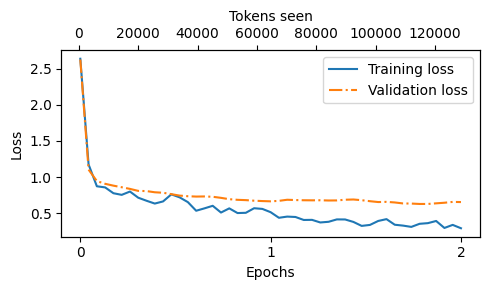

In [167]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# 7.7 extracting and saving response

In [168]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Prid

In [169]:
from tqdm import tqdm
for i , entry in tqdm(enumerate(test_data), total= len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(

        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)


100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


In [170]:
test_data[0]


{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

In [ ]:
len(test_data)

In [171]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")




Model saved as gpt2-medium355M-sft.pth


# 7.8 EVALUATING LLMs

In [1]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [2]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [12]:
import requests  # noqa: F811
import json
# import urllib.request

def query_model(
    prompt,
    model="llama3.2:latest",
    # If you used OLLAMA_HOST=127.0.0.1:11435 ollama serve
    # update the address from 11434 to 11435
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    # Send the POST request
    with requests.post(url, json=data, stream=True, timeout=30) as r:
        r.raise_for_status()
        response_data = ""
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            response_json = json.loads(line)
            if "message" in response_json:
                response_data += response_json["message"]["content"]

    return response_data


model = "llama3.2:latest"
result = query_model("What do Llamas eat?", model)
print(result);


Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a three-part stomach and a large cecum (a specialized part of the large intestine). This allows them to break down and extract nutrients from plant material more efficiently than many other animals. A

In [13]:

for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> To rewrite the sentence using a simile, we need to compare the speed of the car to something else.

Correct output: The car is as fast as lightning.

Score: 100

The model response "The car is as fast as a bullet" is close, but not perfect. A simile should use "like" or "as" to make the comparison, whereas "as fast as a bullet" implies that the car is literally a bullet, which isn't the intended meaning.

A better score for the model response would be around 80-90, as it's close to the correct form but not quite there.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus cloud.

Score:
>> I would rate the model response a 0 out of 100.

The correct answer is "cumulonimbus", not "cumulus". Cumulus clouds are typ

In [18]:
def generate_model_scores(json_data, json_key, model="llama3.2:latest"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model output `{entry[json_key]}` on a scale of 1 to 100. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except:
            continue
    return scores

scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")


Scoring entries: 100%|██████████| 110/110 [04:58<00:00,  2.72s/it]

Number of scores: 96 of 110
Average score: 549.17

